
# Redes Neurais

### Predição em Séries Temporais

- Carregamento dos pacotes necessários
- Geração dos dados
- Modelo preditivo baseado na rede MLP
- Modelo preditivo baseado na rede LSTM
- Exercício de Apoio





## Observações sobre o código

1. Parte do código abaixo foi desenvolvido utilizando o exemplo disponível no respostório do Pytorch abaixo:
https://github.com/pytorch/examples/tree/main/time_sequence_prediction
2. O tempo de execução, em especial para o treinamento da rede LSTM, é bastante longo (aproximadamente 15 minutos)

# Pacotes

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline

## Verificação do processador: GPU ou CPU

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")    

cuda is available.


# Geração dos Dados

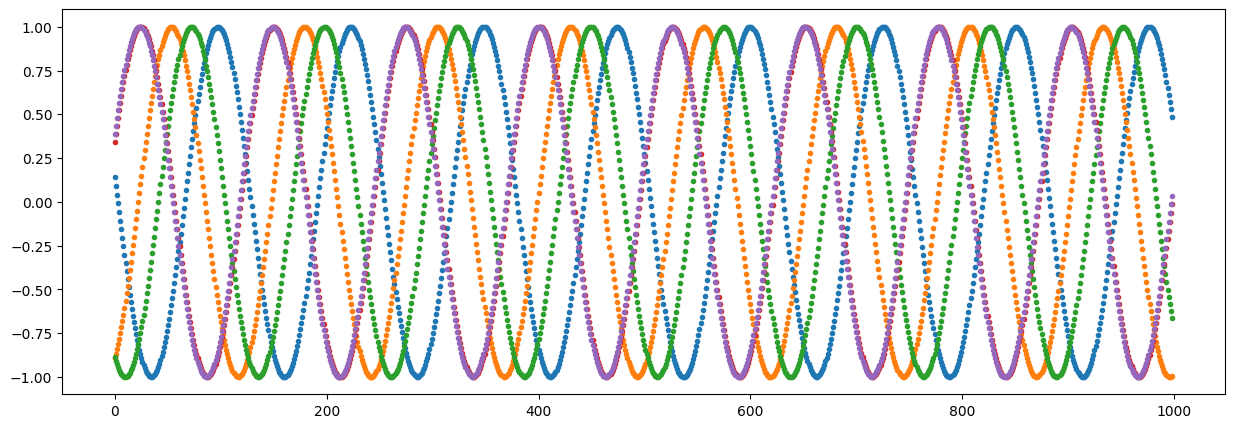

In [4]:
def data_gen():
  np.random.seed(0)
  T = 20
  L = 1000 # comprimento da série gerada (número de pontos)
  N = 100 # número de séries geradas (exemplos)
  x = np.empty((N, L), 'int64')
  x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
  data = np.sin(x / 1.0 / T).astype('float64')
  return data

# Geração dos dados
data = data_gen()

# conversão dos vetores numpy para tensores do Pytorch
#   90 exemplos são utilizados para treino e 10 para teste
x_train = torch.from_numpy(data[10:, :-1])
y_train = torch.from_numpy(data[10:, 1:])
x_test = torch.from_numpy(data[:10, :-1])
y_test = torch.from_numpy(data[:10, 1:])

plt.figure(figsize=(15,5))
plt.plot(np.transpose(x_train[0:5,:].numpy()), '.' )
plt.show()

# Modelo Preditivo (MLP)

## Modelo

In [5]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        self.net = nn.Sequential(
            nn.Linear(999,51),
            nn.Tanh(),
            nn.Linear(51,51),
            nn.Tanh(),
            nn.Linear(51,1),
        )

    def forward(self, input, future = 0):
        outputs = []
        output = self.net(input)
        outputs += [output]

        new_input = torch.cat( (input[:,1:], output),1)
        for i in range(future): # predição do futuro
            output = self.net(new_input)
            outputs += [output]

        outputs = torch.cat(outputs, dim=1)
        return outputs


## Alocação e Laço de Treinamento

In [6]:
np.random.seed(0)
torch.manual_seed(0)
# Criando e alocando o modelo no dispotivo selecionado
mlp = MLP().to(device) 
mlp.double()

# Função de custo
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.0001, amsgrad=True)

x_train = x_train.to(device) # alocando os tensores no dispotivo selecionado
y_train = y_train.to(device)
# laço de treinamento
for i in range(2000):
    optimizer.zero_grad()
    out = mlp(x_train)
    loss = criterion(out[:,0], y_train[:,-1])
    if i%100==0:
        print(i, ' loss:', loss.item())
    loss.backward()
    optimizer.step()
    

0  loss: 0.5820903336371867
100  loss: 0.0024296896503719217
200  loss: 0.0004144651745680175
300  loss: 5.6973913908115755e-05
400  loss: 1.4858016967424443e-05
500  loss: 8.059975239723879e-06
600  loss: 5.482043362682472e-06
700  loss: 4.027093030895122e-06
800  loss: 3.05764869228538e-06
900  loss: 2.3563404332561663e-06
1000  loss: 1.834773774108339e-06
1100  loss: 1.4455224318985318e-06
1200  loss: 1.155972764515841e-06
1300  loss: 9.411345603525927e-07
1400  loss: 7.815133094890542e-07
1500  loss: 6.621428456782219e-07
1600  loss: 5.718153295207586e-07
1700  loss: 5.02340946749087e-07
1800  loss: 4.478584660580904e-07
1900  loss: 4.0423805029171803e-07


## Predição de Valores Futuros

torch.Size([10, 1001])
test loss: 6.813356829842485e-07


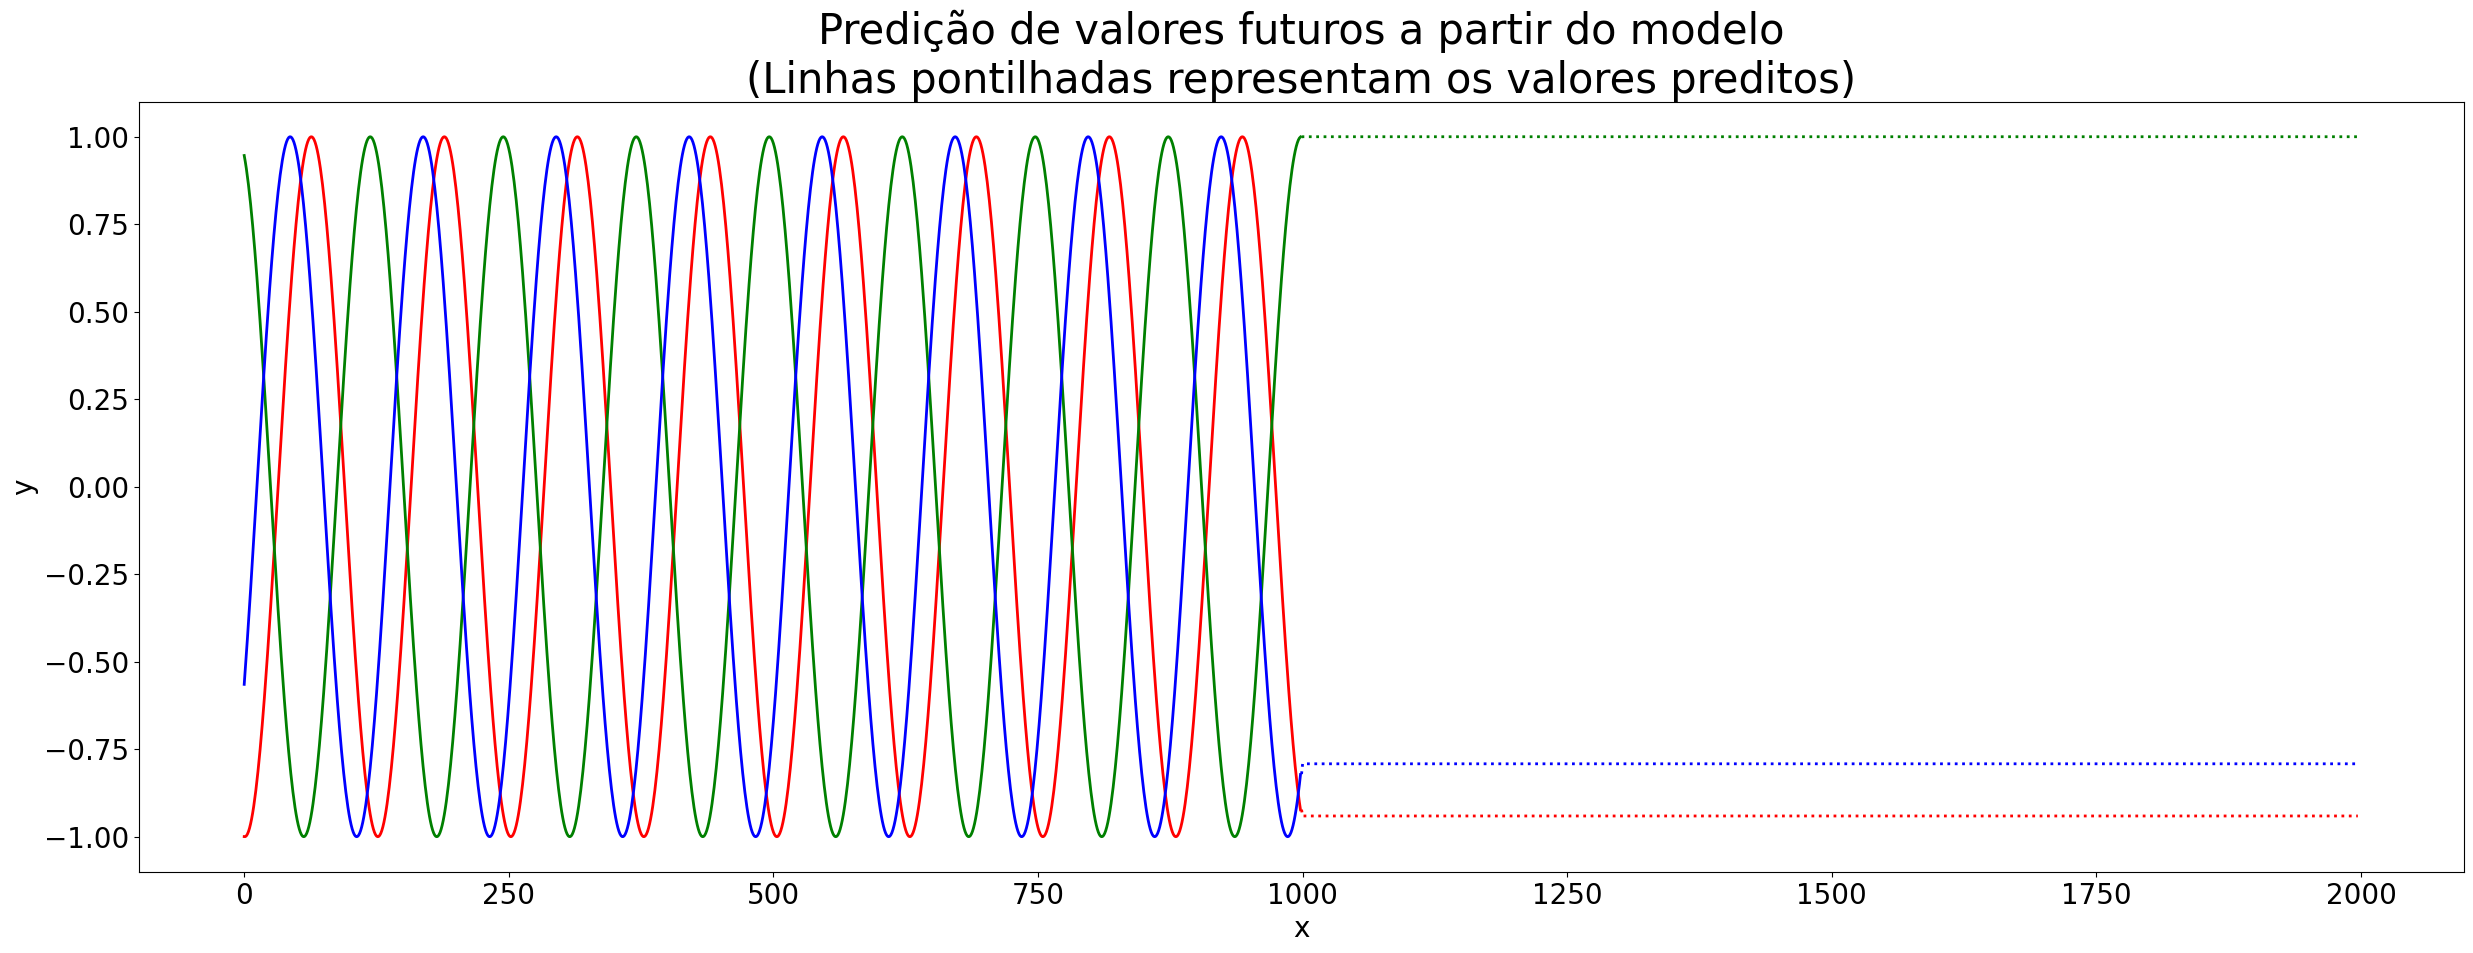

In [7]:
x_test = x_test.to(device)
y_test = y_test.to(device)

# Predição dos valores futuros
with torch.no_grad():
    future = 1000 # definição do número de passos futuros
    pred = mlp(x_test, future=future)
    print(pred.shape)
    loss = criterion(pred[:,0], y_test[:,-1])
    print('test loss:', loss.item())
    y = pred.detach().cpu().numpy()

# Plot dos resultados
plt.figure(figsize=(30,10))
plt.title('Predição de valores futuros a partir do modelo\n(Linhas pontilhadas representam os valores preditos)', fontsize=30)
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
def draw(yo, yf, color):
    plt.plot(np.arange(x_test.size(1)), yo[:x_test.size(1)], color, linewidth = 2.0)
    aaa = np.arange(x_test.size(1), x_test.size(1) + future - 1)
    plt.plot(np.arange(x_test.size(1), x_test.size(1) + future-1), yf[:-2], color + ':', linewidth = 2.0)

draw(y_test[0].cpu().numpy(),y[0], 'r')
draw(y_test[1].cpu().numpy(),y[1], 'g')
draw(y_test[2].cpu().numpy(),y[2], 'b')
plt.show()

# Modelo Preditivo (LSTM)

# Modelo

In [8]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm1 = nn.LSTMCell(1, 51)
        self.lstm2 = nn.LSTMCell(51, 51)
        self.linear = nn.Linear(51, 1)

    def forward(self, input, future = 0):
        outputs = []
        h_t = torch.zeros(input.size(0), 51, dtype=torch.double).to(device)
        c_t = torch.zeros(input.size(0), 51, dtype=torch.double).to(device)
        h_t2 = torch.zeros(input.size(0), 51, dtype=torch.double).to(device)
        c_t2 = torch.zeros(input.size(0), 51, dtype=torch.double).to(device)
        for input_t in input.split(1, dim=1):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]

        for i in range(future):# if we should predict the future
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        
        outputs = torch.cat(outputs, dim=1)
        return outputs


## Alocação e Laço de Treinamento

In [9]:
np.random.seed(0)
torch.manual_seed(0)

# Criando e alocando o modelo no dispotivo selecionado
lstm = LSTM().to(device)
lstm.double()

# Função de cust
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm.parameters(), lr=0.0001, amsgrad=True)

x_train = x_train.to(device)
y_train = y_train.to(device)
# Laço de Treinamento
for i in range(500):
    optimizer.zero_grad()
    out = lstm(x_train) # Propagacão
    loss = criterion(out, y_train) # Cálculo da Função de Custo
    if i%10==0:
        print(i, ' loss:', loss.item())
    loss.backward() # Retropropagação
    optimizer.step() # Atualização dos pesos
    


0  loss: 0.502791627440084
10  loss: 0.4965604675068915
20  loss: 0.49039602990573833
30  loss: 0.4839220160690027
40  loss: 0.4766900919703208
50  loss: 0.46816886491139803
60  loss: 0.45767651257561015
70  loss: 0.4442679147877989
80  loss: 0.42655733470057666
90  loss: 0.40248354543552384
100  loss: 0.3690243556721944
110  loss: 0.32214785368311954
120  loss: 0.25861674232622356
130  loss: 0.1853688592519757
140  loss: 0.1387057609345955
150  loss: 0.128947528240554
160  loss: 0.11460802303214923
170  loss: 0.10472501884387317
180  loss: 0.09613324715346615
190  loss: 0.08838994515356786
200  loss: 0.08140559401043407
210  loss: 0.0748845399362452
220  loss: 0.068753487855975
230  loss: 0.06288071592863234
240  loss: 0.057182771109088315
250  loss: 0.051572134580818954
260  loss: 0.0459565418354527
270  loss: 0.04023133307020479
280  loss: 0.034283740409109496
290  loss: 0.028009748978249007
300  loss: 0.021410266056988234
310  loss: 0.014923039250321754
320  loss: 0.009943046768602

## Predição de Valores Futuros


test loss: 0.002255984534401407


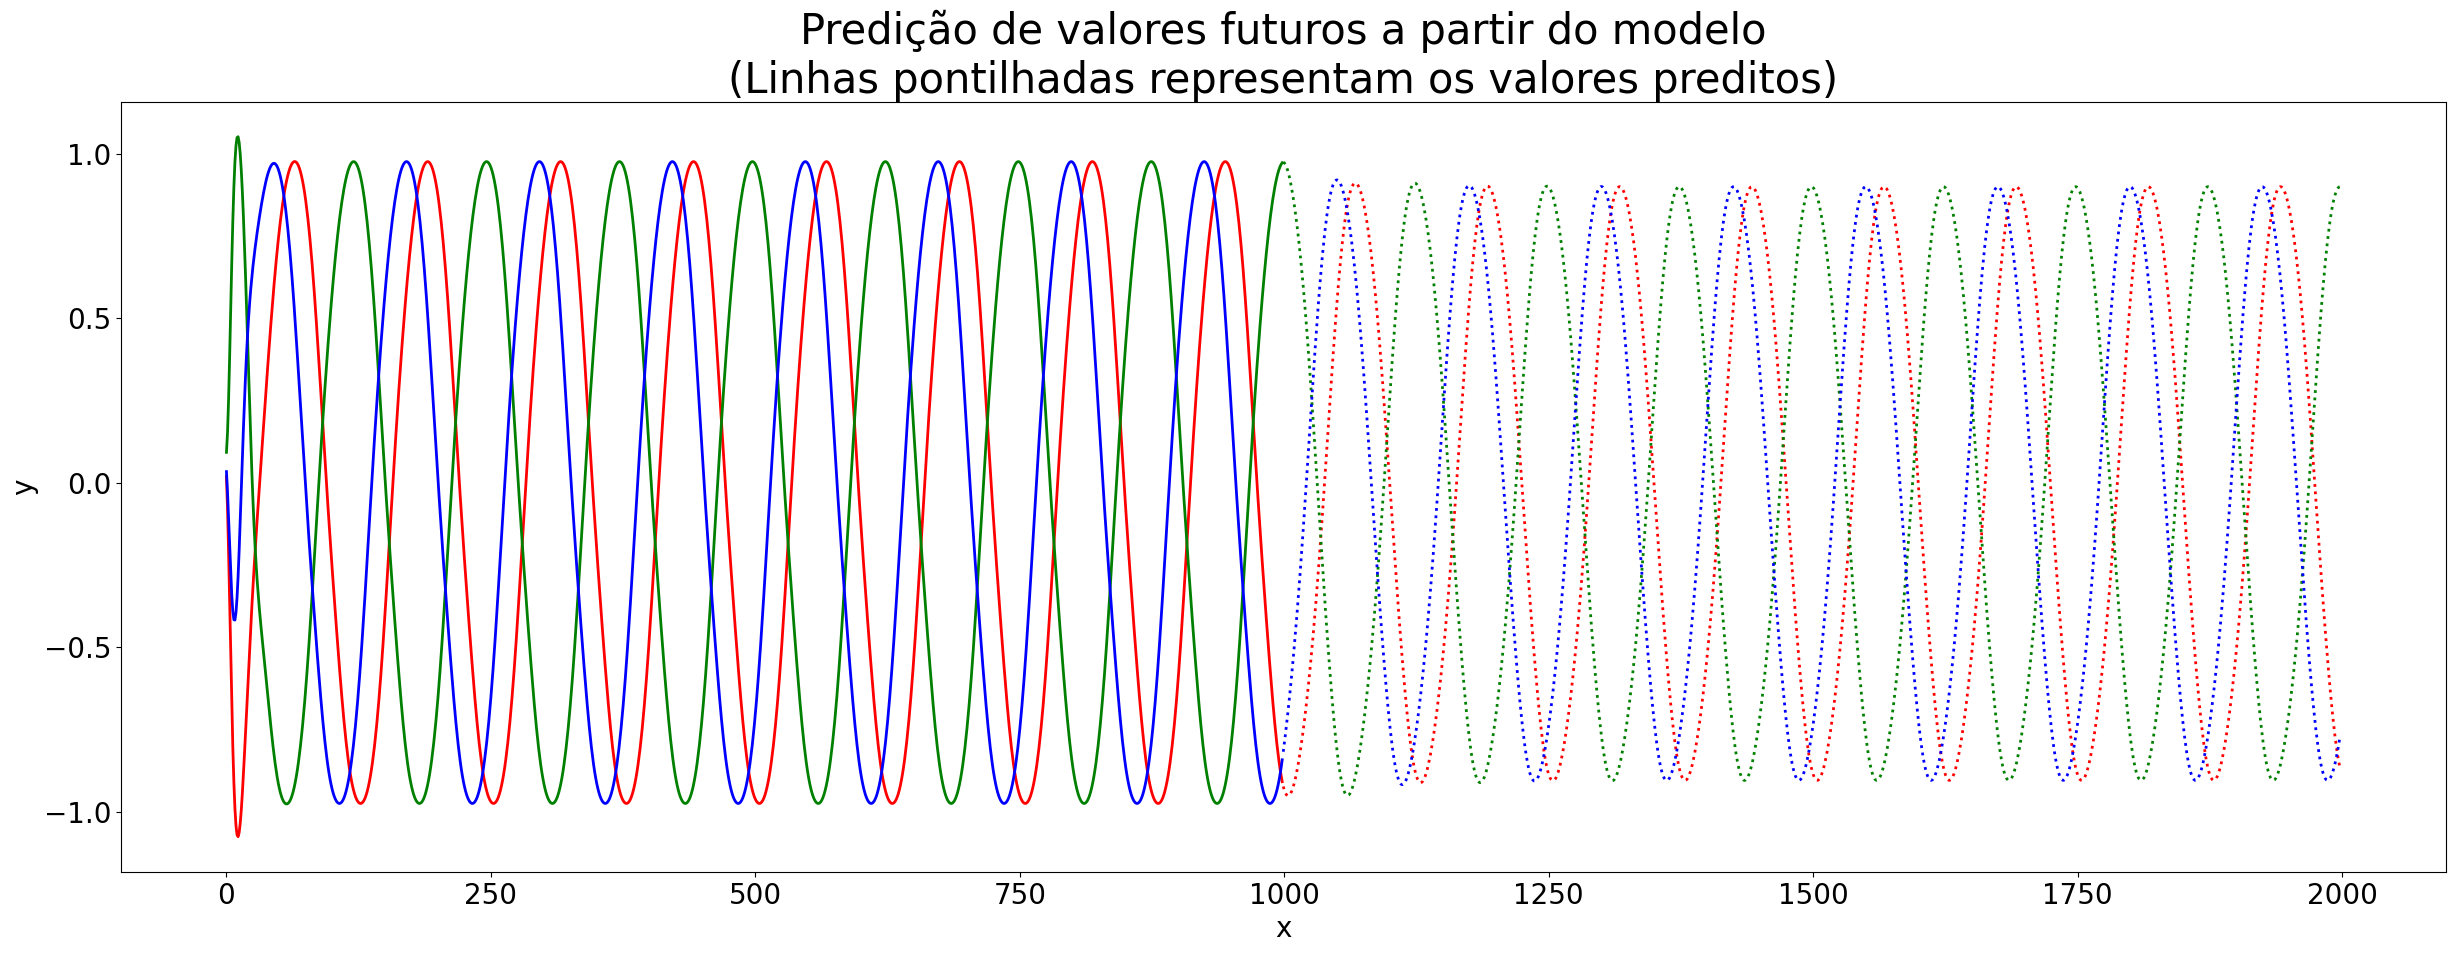

In [10]:
x_test = x_test.to(device)
y_test = y_test.to(device)
with torch.no_grad():
    future = 1000 # número de passos futuros de predição
    pred = lstm(x_test, future=future)
    loss = criterion(pred[:, :-future], y_test)
    print('test loss:', loss.item())
    y = pred.detach().cpu().numpy()

# Plot dos resultados
plt.figure(figsize=(30,10))
plt.title('Predição de valores futuros a partir do modelo\n(Linhas pontilhadas representam os valores preditos)', fontsize=30)
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
def draw(yi, color):
    plt.plot(np.arange(x_test.size(1)), yi[:x_test.size(1)], color, linewidth = 2.0)
    plt.plot(np.arange(x_test.size(1), x_test.size(1) + future), yi[x_test.size(1):], color + ':', linewidth = 2.0)
draw(y[0], 'r')
draw(y[1], 'g')
draw(y[2], 'b')
plt.show()